In [1]:
!pip install imageio
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# save video
# https://stackoverflow.com/questions/60765613/how-to-show-episode-in-rendered-openai-gym-environment
# Credit to ChatGPT
import os
import imageio
import numpy as np
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt    
import gymnasium
import numpy as np
import cv2
from IPython.display import clear_output
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)
    return im

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, OUTPUT_SIZE):
        super(NeuralNetwork, self).__init__()
        layers = []
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        layers.append(nn.Linear(4, 8))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(8, 16))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(16, 32))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(32, 64))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(64, OUTPUT_SIZE))
        self.stack = nn.Sequential(*layers)
    def forward(self, x):
        return self.stack(x)

In [5]:
def greedyAction(env, model, epsilon):
    prob = np.random.random()
    isGreedy = (prob < epsilon)
    if isGreedy:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = torch.argmax(model(torch.tensor(obs).float().unsqueeze(0)).to(device))
            action = action.item()
    return(action)

In [12]:
expReplay = []
env = gymnasium.make("CartPole-v1", render_mode = "rgb_array")# https://gymnasium.farama.org/environments/box2d/car_racing/
terminated = False
epsilon = 0.8
alpha = 0.4
gamma = 0.8
DECAY_RATE = 0.01
EPSILON_FLOOR = 0.01
frames = []
rewardEp = []
movingAvg = []
MAXACTIONS = 2
N_EPISODES = 130
REWARD_AVG_EPS = 100
learningRate = 0.001
replayCapacity = 100
minibatchSize = 45

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
Q = NeuralNetwork(MAXACTIONS).to(device)
loss = torch.nn.MSELoss()
adam = torch.optim.NAdam(Q.parameters(), lr = learningRate)

Using cpu device


Episode 129
Epsilon = 0.2187913208177733
Reward = 191.0
MovingAvgReward = 77.78


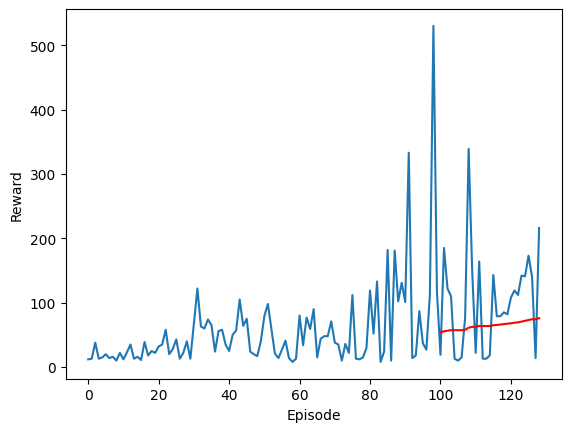

In [14]:
for episode in range(N_EPISODES):
  print("Episode " + str(episode))
  print("Epsilon = " + str(epsilon))
  obs, _ = env.reset()
  #print(obs.shape)
  totalReward = 0
  while not terminated:
    adam.zero_grad()
    action = greedyAction(env, Q, epsilon)
    newObs, reward, terminated, truncated, _ = env.step(action)
    #print(newObs.shape)
    totalReward += reward
    if len(expReplay) > replayCapacity:
        expReplay = expReplay[1:]
    #print([obs, action, reward, newObs, terminated])
    expReplay.append([obs, action, reward, newObs, terminated])
    if len(expReplay) >= minibatchSize:
        #print(expReplay)
        minibatch = np.random.choice(range(len(expReplay)), size = minibatchSize, replace = False)
         
        initStates = [expReplay[m][0] for m in minibatch]
        #print([initStates[i].shape for i in range(len(initStates))])
        actions = [expReplay[m][1] for m in minibatch]
        rewards = [expReplay[m][2] for m in minibatch]
        nextStates = [expReplay[m][3] for m in minibatch]
        terminatedTens = [expReplay[m][4] for m in minibatch]
        notTerminatedTens = [not t for t in terminatedTens]

        # Convert to action indices
        initStates = torch.tensor(initStates).float().to(device)
        #print(initStates.shape)
        actions = torch.tensor(actions).int().to(device)
        rewards = torch.tensor(rewards).float().to(device).unsqueeze(1)
        nextStates = torch.tensor(nextStates).float().to(device)
        terminatedTens = torch.tensor(terminatedTens).float().to(device).unsqueeze(1)
        notTerminatedTens = torch.tensor(notTerminatedTens).float().to(device).unsqueeze(1)
        #print("nextStates.shape: " + str(nextStates.shape))
        with torch.no_grad():
            maxQ = torch.mul(torch.max(Q(nextStates), 1)[0].unsqueeze(1), notTerminatedTens)
    
        y = torch.add(rewards, torch.mul(maxQ, gamma))
        q = Q(initStates)
        # Gather Q(state, action)
        q = q[torch.arange(initStates.size(0)), actions].unsqueeze(1)
        diff = loss(q, y)
        diff.backward()
        adam.step()
    frame = env.render()
    frames.append(_label_with_episode_number(frame, episode_num = episode))
    obs = newObs.copy()
  epsilon *= 1 - DECAY_RATE
  if epsilon < EPSILON_FLOOR:
      epsilon = EPSILON_FLOOR
  terminated = False
  print("Reward = " + str(totalReward))
  rewardEp.append(totalReward)
  if episode > REWARD_AVG_EPS - 1:
    movingAvgReward = np.mean(rewardEp[-REWARD_AVG_EPS:])
    movingAvg.append(movingAvgReward)
    print("MovingAvgReward = " + str(movingAvgReward))
  else:
    movingAvgReward = 0
    movingAvg.append(None)
  # Plot the reward
  plt.figure(0)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(np.array(rewardEp[:episode]))
  plt.plot(np.array(movingAvg[:episode]), color = 'red')
  plt.show()
  if episode < N_EPISODES - 1:
    clear_output(wait = True)
#imageio.mimwrite(os.path.join('./videos/', 'q_learning.gif'), frames, fps=60000)

In [15]:
# Specify the video frame size
frame_width, frame_height = frames[0].size  # Assuming all images have the same size

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
out = cv2.VideoWriter('./videos/output_video_cartpole.mp4', fourcc, 25.0, (frame_width, frame_height))

# Loop through each image
for pil_image in frames:
    # Convert PIL image to NumPy array
    np_image = np.array(pil_image)
    # Convert RGB to BGR (OpenCV uses BGR)
    frame = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    out.write(frame)

# Release the VideoWriter object
out.release()

In [16]:
torch.save(Q, "dqn_model.pt")

# Testing

In [22]:
env = gymnasium.make("CartPole-v1", render_mode = "rgb_array")# https://gymnasium.farama.org/environments/box2d/car_racing/

Episode 199
Epsilon = 0.21660340760959557
Reward = 182.0
MovingAvgReward = 204.16


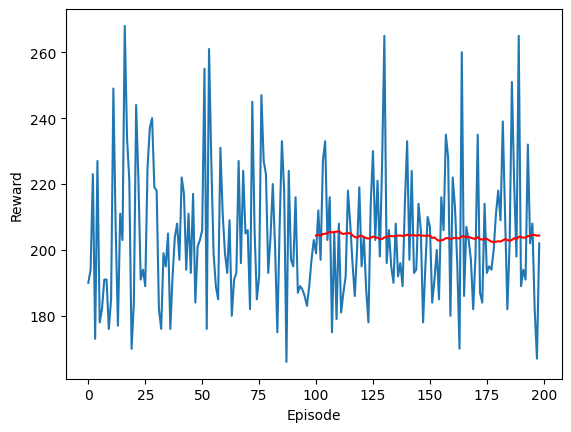

In [23]:
N_EPISODES = 200
frames = []
rewardEp = []
movingAvg = []
for episode in range(N_EPISODES):
  print("Episode " + str(episode))
  print("Epsilon = " + str(epsilon))
  obs, _ = env.reset()
  #print(obs.shape)
  totalReward = 0
  while not terminated:
    action = greedyAction(env, Q, 0)
    newObs, reward, terminated, truncated, _ = env.step(action)
    totalReward += reward
    frame = env.render()
    frames.append(_label_with_episode_number(frame, episode_num = episode))
    obs = newObs.copy()
  terminated = False
  print("Reward = " + str(totalReward))
  rewardEp.append(totalReward)
  if episode > REWARD_AVG_EPS - 1:
    movingAvgReward = np.mean(rewardEp[-REWARD_AVG_EPS:])
    movingAvg.append(movingAvgReward)
    print("MovingAvgReward = " + str(movingAvgReward))
  else:
    movingAvgReward = 0
    movingAvg.append(None)
  # Plot the reward
  plt.figure(0)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(np.array(rewardEp[:episode]))
  plt.plot(np.array(movingAvg[:episode]), color = 'red')
  plt.show()
  if episode < N_EPISODES - 1:
    clear_output(wait = True)
#imageio.mimwrite(os.path.join('./videos/', 'q_learning.gif'), frames, fps=60000)

In [24]:
# Specify the video frame size
frame_width, frame_height = frames[0].size  # Assuming all images have the same size

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
out = cv2.VideoWriter('./videos/output_video_cartpole_test.mp4', fourcc, 25.0, (frame_width, frame_height))

# Loop through each image
for pil_image in frames:
    # Convert PIL image to NumPy array
    np_image = np.array(pil_image)
    # Convert RGB to BGR (OpenCV uses BGR)
    frame = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    out.write(frame)

# Release the VideoWriter object
out.release()